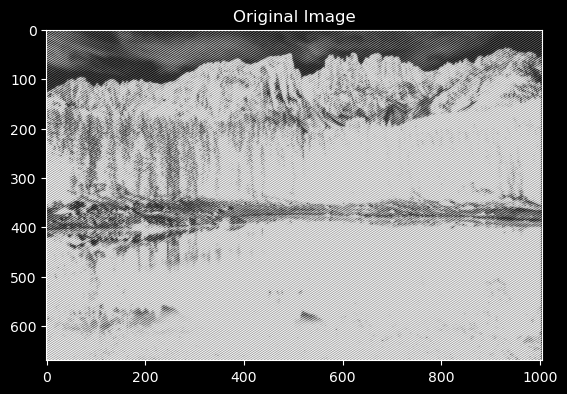

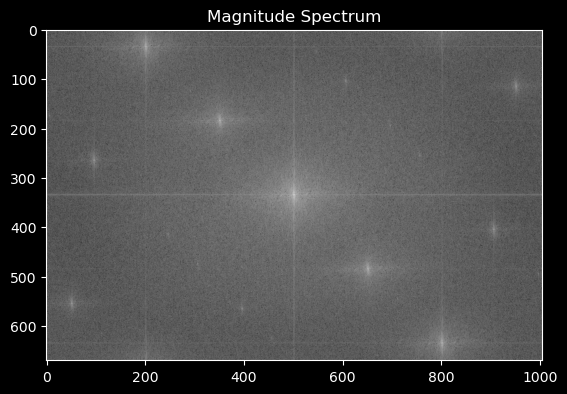

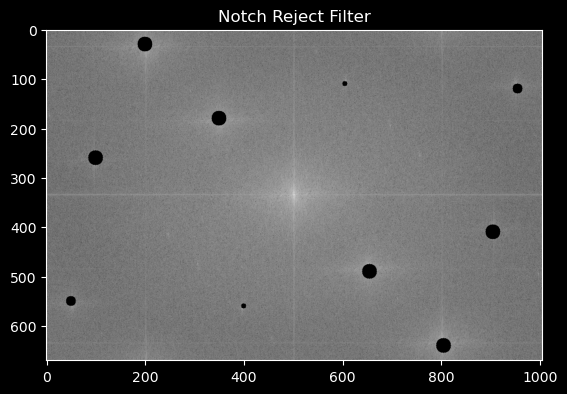

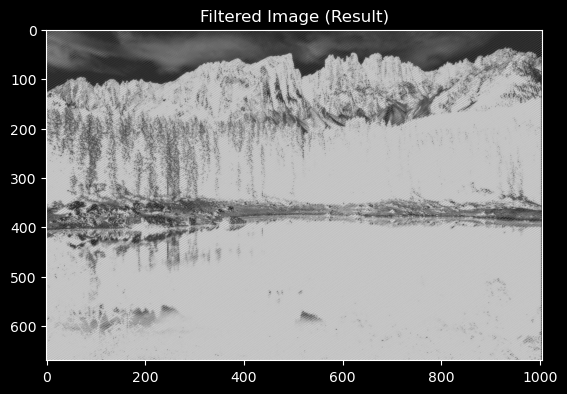

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
def notch_reject_filter(shape, d0=9, x=0, y=0):
    """
    建立 Notch Reject 濾波器。
    濾波器會針對頻譜中的某一區域及其對稱點進行屏蔽。

    Parameters:
    - shape: 影像的大小 (rows, cols)
    - d0: 半徑大小，控制濾波範圍
    - x, y: 濾波器中心點，使用左上角 (0, 0) 為基準的座標

    Returns:
    - H: Notch 濾波器 (2D numpy array)
    """
    P, Q = shape
    H = np.ones((P, Q))  # 初始化為全通濾波器 (值為1)

    # 將座標轉換到頻譜中心
    u_k = x - Q / 2
    v_k = y - P / 2

    # 針對頻譜每個點計算距離，決定是否濾波
    for v in range(P):
        for u in range(Q):
            # 計算距離 (針對目標頻率點和對稱頻率點)
            D_uv = np.sqrt((v - P / 2 + v_k) ** 2 + (u - Q / 2 + u_k) ** 2)
            D_muv = np.sqrt((v - P / 2 - v_k) ** 2 + (u - Q / 2 - u_k) ** 2)

            # 如果在半徑範圍內，設為0 (濾波區域)
            if D_uv <= d0 or D_muv <= d0:
                H[v, u] = 0.0

    return H
#------------------------------------------------------

# 1. 讀取影像
img = cv2.imread('04_image.jpg',0)  # 讀取灰階影像

# 2. 進行傅立葉轉換，轉換到頻域
f = np.fft.fft2(img)  # 計算傅立葉變換
fshift = np.fft.fftshift(f)  # 將低頻移到中心位置
magnitude_spectrum = 20 * np.log(np.abs(fshift))  # 計算頻譜 (取對數以增強可視化效果)

# 3. 獲取影像尺寸
img_shape = img.shape

# 4. 設計 Notch 濾波器，針對特定頻率區域屏蔽
H1 = notch_reject_filter(img_shape, d0=15, x=100, y=260)
H2 = notch_reject_filter(img_shape, d0=10, x=50, y=550)
H3 = notch_reject_filter(img_shape, d0=15, x=200, y=30)
H4 = notch_reject_filter(img_shape, d0=15, x=350, y=180)
H5 = notch_reject_filter(img_shape, d0=5, x=400, y=560)


# 5. 合併多個濾波器
NotchFilter = H1*H2*H3*H4*H5  # 將多個濾波器相乘，覆蓋多個區域

# 6. 應用濾波器，濾除選定頻率
NotchRejectCenter = fshift * NotchFilter  # 在頻域乘上濾波器
NotchReject = np.fft.ifftshift(NotchRejectCenter)  # 反向位移，將頻譜移回原位置
inverse_NotchReject = np.fft.ifft2(NotchReject)  # 進行逆傅立葉變換
Result = np.abs(inverse_NotchReject)  # 計算結果影像的幅值

# 7. 顯示結果
# 原始影像
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

# 頻譜圖
plt.imshow(magnitude_spectrum, cmap='gray')
cv2.imwrite("car_magnitude.jpg", magnitude_spectrum)  # 儲存頻譜影像
plt.title('Magnitude Spectrum')
plt.show()

# 濾波器作用後的頻譜
plt.imshow(magnitude_spectrum * NotchFilter, cmap="gray")
plt.title("Notch Reject Filter")
plt.show()

# 濾波後的影像結果
plt.imshow(Result, cmap="gray")
plt.title("Filtered Image (Result)")
plt.show()
